In [1]:
%matplotlib inline

import itertools

import pandas as pd
import scipy.stats

def corr(df, left, right, func='pearsonr', left_replace=None):
    df = df[[left, right]].dropna()
    left = df[left].replace(left_replace) if left_replace is not None else df[left]
    right = df[right]
    result = getattr(scipy.stats, func)(left, right)
    return pd.Series(result, name=func, index=('r', 'p'))

FILE = 'MarkingDataNominal.txt'

tb = pd.read_csv(FILE, delimiter='\t')
tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 5 columns):
Semantic class    756 non-null object
Language          756 non-null object
Pred              748 non-null object
Ref               697 non-null object
Mod               697 non-null object
dtypes: object(5)
memory usage: 29.6+ KB


In [2]:
tb.head()

,Semantic class,Language,Pred,Ref,Mod
0,proper name,Mekeo,yes,yes,NaN
1,person,Mekeo,yes,yes,sometimes
2,kin term,Mekeo,yes,yes,NaN
3,body part,Mekeo,yes,yes,NaN
4,natural kind,Mekeo,yes,yes,NaN


In [3]:
tb['Language'].value_counts().value_counts()

21    36
Name: Language, dtype: int64

In [4]:
tb['Semantic class'].value_counts().value_counts()

36    21
Name: Semantic class, dtype: int64

In [5]:
tb = tb.set_index(['Language', 'Semantic class'])
assert tb.index.is_unique

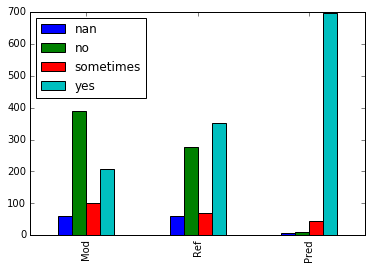

In [6]:
prm = tb.fillna('nan').stack().groupby(level=-1).value_counts().unstack().iloc[::-1]
prm.plot(kind='bar');

In [7]:
prm.eval('yes_ratio = 100 * yes / (nan + no + sometimes + yes)', inplace=False)

,nan,no,sometimes,yes,yes_ratio
Mod,59,388,101,208,27.513228
Ref,59,276,68,353,46.693122
Pred,8,9,43,696,92.063492


In [8]:
s = tb.stack(dropna=False)
s.index = s.index.set_names('Function', level=2)
df = s.to_frame('Without coding').reset_index()
df.head()

,Language,Semantic class,Function,Without coding
0,Mekeo,proper name,Pred,yes
1,Mekeo,proper name,Ref,yes
2,Mekeo,proper name,Mod,NaN
3,Mekeo,person,Pred,yes
4,Mekeo,person,Ref,yes


In [9]:
VALUES = {'no': 0.0, 'sometimes': 0.5, 'yes': 1.0}
df['value'] = df['Without coding'].replace(VALUES)
df.head()

,Language,Semantic class,Function,Without coding,value
0,Mekeo,proper name,Pred,yes,1.0
1,Mekeo,proper name,Ref,yes,1.0
2,Mekeo,proper name,Mod,NaN,NaN
3,Mekeo,person,Pred,yes,1.0
4,Mekeo,person,Ref,yes,1.0


In [10]:
scales = pd.DataFrame([(' > '.join(reversed(p)), {c: i for i, c in enumerate(p)})
    for p in itertools.permutations(df['Function'].unique())],
    columns=['scale', 'replace']).set_index('scale')

scalesc = scales['replace'].apply(lambda r: corr(df, 'Function', 'value', 'spearmanr', r))
scales = scales.join(scalesc).sort_values('r', ascending=False)
scales

,replace,r,p
scale,,,
Pred > Ref > Mod,"{u'Pred': 2, u'Ref': 1, u'Mod': 0}",0.538333,3.024327e-161
Pred > Mod > Ref,"{u'Pred': 2, u'Ref': 0, u'Mod': 1}",0.377331,1.926679e-73
Ref > Pred > Mod,"{u'Pred': 1, u'Ref': 2, u'Mod': 0}",0.166892,7.596503e-15
Mod > Pred > Ref,"{u'Pred': 1, u'Ref': 0, u'Mod': 2}",-0.166892,7.596503e-15
Ref > Mod > Pred,"{u'Pred': 0, u'Ref': 2, u'Mod': 1}",-0.377331,1.926679e-73
Mod > Ref > Pred,"{u'Pred': 0, u'Ref': 1, u'Mod': 2}",-0.538333,3.024327e-161


https://en.wikipedia.org/wiki/Rank_correlation

https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient

https://en.wikipedia.org/wiki/Kendall's_tau_rank_correlation_coefficient

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.spearmanr.html

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.kendalltau.html

In [11]:
CORR = ['pearsonr', 'spearmanr', 'kendalltau']
scale = scales.at['Pred > Ref > Mod', 'replace']
pd.DataFrame([corr(df, 'Function', 'value', c, scale) for c in CORR])

,r,p
pearsonr,0.533537,6.863377e-158
spearmanr,0.538333,3.024327e-161
kendalltau,0.488921,4.080001e-252


In [12]:
PROPWORDS = ['dimension', 'color', 'value', 'age', 'phys.prop', 'hum.prop', 'exp.state']
pw = df[(df['Function'] == 'Mod') & df['Semantic class'].isin(PROPWORDS)]
pw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 23 to 2246
Data columns (total 5 columns):
Language          252 non-null object
Semantic class    252 non-null object
Function          252 non-null object
Without coding    232 non-null object
value             232 non-null float64
dtypes: float64(1), object(4)
memory usage: 11.8+ KB


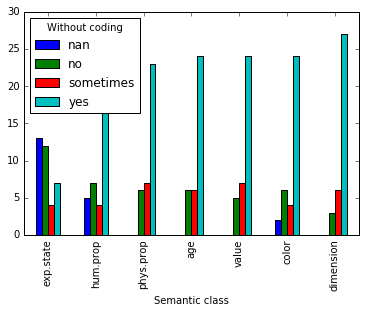

In [13]:
pwsc = pw.groupby('Semantic class')['Without coding']\
    .value_counts(dropna=False).rename(index={pd.np.nan: 'nan'})\
    .unstack('Without coding', fill_value=0).loc[PROPWORDS[::-1]]
pwsc.plot(kind='bar');

In [14]:
pwsc.eval('yes_ratio = 100 * yes / (nan + no + sometimes + yes)', inplace=False)

Without coding,nan,no,sometimes,yes,yes_ratio
Semantic class,,,,,
exp.state,13,12,4,7,19.444444
hum.prop,5,7,4,20,55.555556
phys.prop,0,6,7,23,63.888889
age,0,6,6,24,66.666667
value,0,5,7,24,66.666667
color,2,6,4,24,66.666667
dimension,0,3,6,27,75.000000


In [15]:
pws = pd.DataFrame([(' > '.join(reversed(p)), {c: i for i, c in enumerate(p)})
    for p in itertools.permutations(pw['Semantic class'].unique())],
    columns=['scale', 'replace']).set_index('scale')

pwc = pws['replace'].apply(lambda r: corr(pw, 'Semantic class', 'value', 'spearmanr', r))
pws = pws.join(pwc).sort_values('r', ascending=False)
pws[['r', 'p']].head()

,r,p
scale,,
dimension > color > value > age > phys.prop > hum.prop > exp.state,0.205040,0.001692
dimension > color > age > value > phys.prop > hum.prop > exp.state,0.203334,0.001852
dimension > color > value > age > hum.prop > phys.prop > exp.state,0.202659,0.001920
dimension > value > color > age > phys.prop > hum.prop > exp.state,0.202094,0.001978
dimension > color > value > phys.prop > age > hum.prop > exp.state,0.201196,0.002073


In [16]:
scale = pws.at['dimension > color > value > age > phys.prop > hum.prop > exp.state', 'replace']
pd.DataFrame([corr(pw, 'Semantic class', 'value', c, scale) for c in CORR])

,r,p
pearsonr,0.222158,0.000654
spearmanr,0.205040,0.001692
kendalltau,0.172183,0.000094


In [17]:
scale = {'dimension': 4,
    'color': 3, 'value': 3, 'age': 3, 
    'phys.prop': 2, 'hum.prop': 1, 'exp.state': 0}
pd.DataFrame([corr(pw, 'Semantic class', 'value', c, scale) for c in CORR])

,r,p
pearsonr,0.248509,0.000131
spearmanr,0.209724,0.001314
kendalltau,0.183687,0.000031
